##*Elizabeth Torres Torrecillas* 

# *Actividad 6*



---

---

---







In [60]:
#Importar bibliotecas a utilizar 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#Herramientas nuevas a utilizar
from statsmodels.tsa.stattools import adfuller
import pandas.util.testing as tm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

#Matplotlib mostrará los resultados en la Notebook de Jupyter 
%matplotlib inline

Tratamiento de datos

In [61]:
#En esta celda se hacen todas las operaciones de preparar el DataFrame df_meteo

#Guardamos el archivo .txt que subimos a Github en la variable url
url='https://raw.githubusercontent.com/elizabethtorrest/Fisica-Computacional/F%C3%ADsica-Computacional/Actividad6/Climatologia%20Imuris%20Sonora.txt'

# Definimos los nombres de las columnas
type_data = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']

#leemos el archivo .txt que subimos a github y lo convertimos a csv
df_dist=pd.read_csv(url, names=type_data, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')

#Hacemos una copia del trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)

#Convertimos los valores de las variables ambientales a números flotantes
inf_met = ['Precip', 'Evap', 'Tmax', 'Tmin']
for inf in inf_met:
  df_work1[inf] = pd.to_numeric(df_work1[inf], errors='coerce')

#Definimos un nuevo DataFrame por si hay que regresarse.
df_work2 = df_work1.copy()

#Aquí vamos a convertir del tipo objeto a el formato que el lenguaje utilizado comprende
#Esto ya que la variable tipo fecha de Python, contiene mucha información condensada
#La función pd.to_datetime convierte una cadena en tipo datetime64[ns]
# Agregamos la opción de que el primer dato es el día (dayfirst=True) 
df_work2['Fecha'] = pd.to_datetime(df_work2['Fecha'], dayfirst=True). copy()

#Formato de año
df_work2['Año'] = df_work2['Fecha'].dt.year
#Formato de mes
df_work2['Mes'] = df_work2['Fecha'].dt.month

#Definimos un nuevo DataFrame para el análisis de los datos meteorológicos
df_meteo = df_work2.copy()
#Imprimir y verificar
#df_meteo.info()
#print(df_meteo.head())
#print(df_meteo.tail())

# Hacemos una copia del último DataFrame para realizar nuevas operaciones
df_meteo_ts = df_meteo.copy()

# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_meteo_ts = df_meteo_ts.set_index('Fecha')

# Verificamos que se haya realizado correctamente 
df_meteo_ts.info()
#print(df_meteo_ts.head())
#print(df_meteo_ts.tail())

# Seleccionamos un conjunto de años, creando colecciones de datos 
#Seleccionaremos el primer conjuntos de años
df_90_1 = df_meteo_ts[(df_meteo_ts['Año'] >= 1981) & (df_meteo_ts['Año'] < 1990)]
#Seleccionaremos el segundo conjunto de años
df_90_2 = df_meteo_ts[(df_meteo_ts['Año'] >= 1990) & (df_meteo_ts['Año'] < 2016)]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12139 entries, 1981-01-01 to 2016-04-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  12134 non-null  float64
 1   Evap    0 non-null      float64
 2   Tmax    11972 non-null  float64
 3   Tmin    11979 non-null  float64
 4   Año     12139 non-null  int64  
 5   Mes     12139 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 663.9 KB


* Definimos una función para probar la estacionaridad de una Serie de Tiempo

In [62]:
#Para probar la estacionaridad, haremos uso de La Prueba Aumentada de Dickey-Fuller (ADF)
#La función para probar la estacionaridad de una serie de tiempo: 'timeseries'
def test_stationarity(df_ts):
    
    #Determinamos la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    #Definimoa el tamaño de la gráfica 
    plt.rcParams["figure.figsize"] = (12,6)

    ###Graficamos la Estadística de promedios móviles 
    #Graficamos la serie 
    plt.plot(df_ts, color='blue',label='Original')
    #Graficamos el promedio movil 
    plt.plot(rolmean, color='red', label='Rolling Mean')
    #Graficamos la desviación estandar 
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    #Se desea que la gráfica tenga una malla
    plt.grid()
    plt.show()
 
 ##Si el valor de "p" es menor a 5%, la serie es estacionaria
 ##Si el valor de "p" es mayor a 5% la serie NO ES ESTACIONARIA, entonces le hacemos un tratamiento hasta lograrlo.
    #Realizamos la Prueba Aumentada de Dickey-Fuller 
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

* Definimos la Serie de Tiempo

In [63]:
##EL FRESNAL
#Declaramos nuestra primer Serie de Tiempo 
#Hacemos una copia del periodo de tiempo seleccionado (No funciona cuando hace falta un rango de datos)
#filtramos nuestra información 
inicio, fin = '1986-11', '1998-11'
ts_90 = df_90_2.loc[inicio:fin].copy()
ts_90.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
1990-01-01,0.0,NaN,20.0,1.0,1990,1
1990-01-02,5.0,NaN,16.5,1.5,1990,1
1990-01-03,0.0,NaN,12.0,2.5,1990,1
1990-01-04,0.0,NaN,16.5,-1.0,1990,1
1990-01-05,6.0,NaN,17.0,-1.5,1990,1


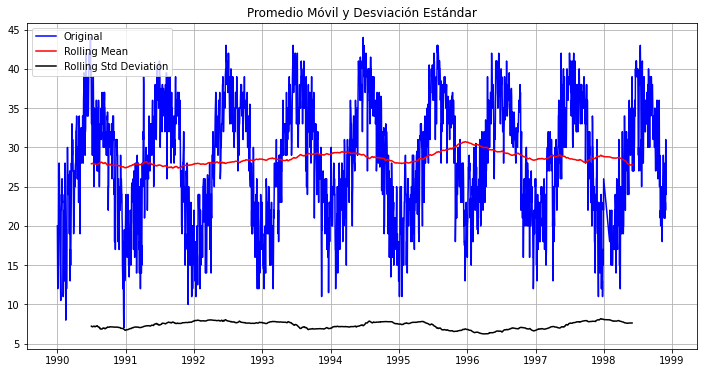

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.924588
p-value                           0.001861
#Lags Used                       16.000000
Number of Observations Used    3208.000000
Critical Value (1%)              -3.432390
Critical Value (5%)              -2.862441
Critical Value (10%)             -2.567250
dtype: float64


In [64]:
##EL FRESNAL 
#Definimos la Serie de Tiempo que estudiaremos primero, en este caso Tmax
ts_test_tmax = ts_90['Tmax'].copy()
#se la damos como argumento a la prueba 
test_stationarity(ts_test_tmax)

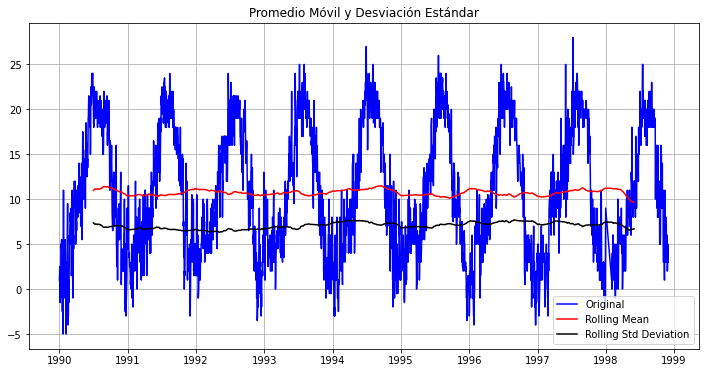

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.235659
p-value                           0.018011
#Lags Used                       12.000000
Number of Observations Used    3212.000000
Critical Value (1%)              -3.432388
Critical Value (5%)              -2.862440
Critical Value (10%)             -2.567249
dtype: float64


In [65]:
##EL FRESNAL
#Definimos la Serie de Tiempo que estudiaremos, en este caso Tmin
ts_test_tmin = ts_90['Tmin'].copy()
#se la damos como argumento a la prueba 
test_stationarity(ts_test_tmin)

* Cuando el promedio móvil no es constante, siendo el valor p de ADF: p > 0.05

  La ***tendencia*** y la ***estacionalidad*** hacen que una serie no sea estacionaria.

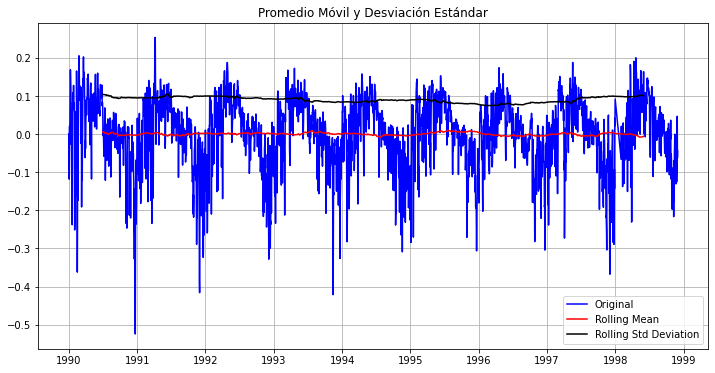

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -4.636207
p-value                           0.000111
#Lags Used                       24.000000
Number of Observations Used    3200.000000
Critical Value (1%)              -3.432395
Critical Value (5%)              -2.862444
Critical Value (10%)             -2.567251
dtype: float64


In [66]:
#Aunque la serie es estacionaria para ambas,promedio móvil constante, ya que
#p es menor a 5%,procederemos a linealizarlas para mostrar cómo es que esta
#mejora, esto a partir del tratamiento que se les realizará a continuación
#aclarando que hay muchas formas para reducir la tendencia. El punto es hacer
#cambio de escalas, disminuyendo así la tendencia para valores grandes de x.
#como pueden ser con log(x), sqrt(x), raiz_cúbica(x),... 

##EJEMPLO
#TEMPERATURAS MÁXIMAS
#El cambio de escala se realizará con base en la función exponencial
#Graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test_tmax)
#Cambiamos el tipo de Promedio móvil a exponencial
EWM_avg = ts_test_log.ewm(halflife=30).mean()
#Estacionaridad de la diferencial
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg

ts_test_log_EWM_avg_diff.dropna(inplace=True)
ts_test_log_EWM_avg_diff.head()
#Probamos la estacionaridad de la nueva serie de tiempo escalada en exponencial
test_stationarity(ts_test_log_EWM_avg_diff)

#OBSERVACIÓN: VALOR DE P DISMINUYE.

Procedemos a eliminar la Estacionalidad, los métodos para realizarlo son:
*   Diferenciación discreta (calcular diferencias involucrando un corrimiento 'shift()')
*   Descomposición (Tendencia + Estacionalidad + Residuo) - lo vimos en la actividad pasada. 

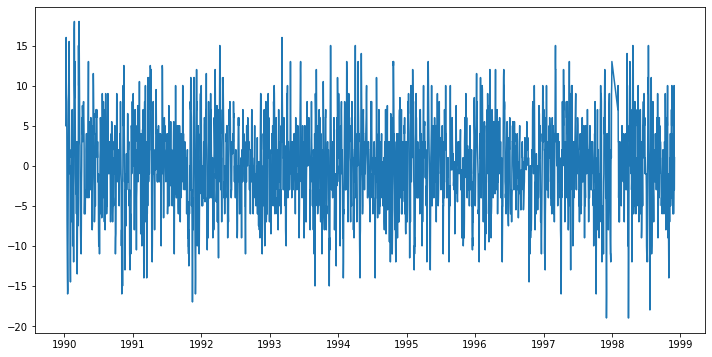

In [67]:
##TEMPERATURA MÁXIMA
#Diferenciamos usando la función df.shift()
ts_test_log_diff =ts_test_tmax - ts_test_tmax.shift(periods=7)
plt.plot(ts_test_log_diff);

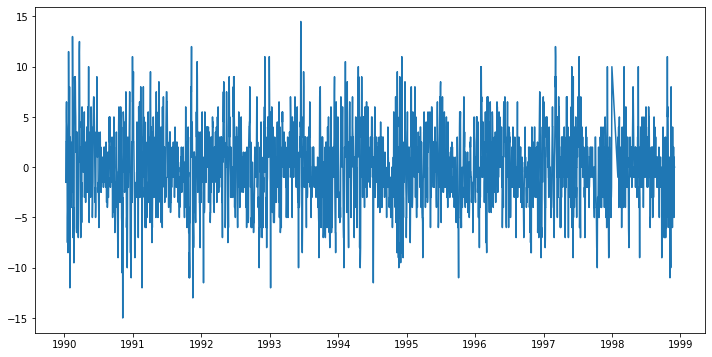

In [68]:
##TEMPERATURA MÍNIMA
#Diferenciamos usando la función df.shift()
ts_test_log_diff_2 =ts_test_tmin - ts_test_tmin.shift(periods=7)
plt.plot(ts_test_log_diff_2);

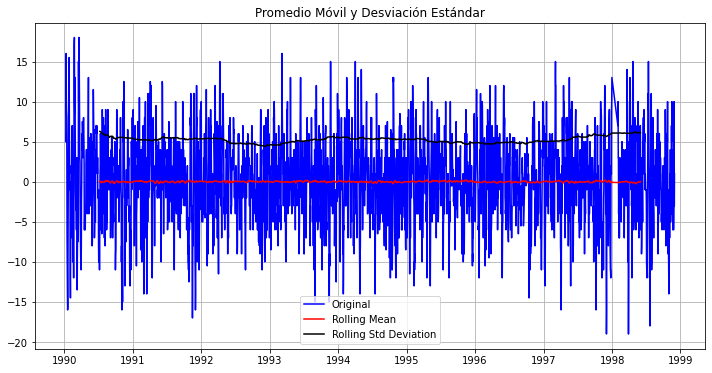

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.104132e+01
p-value                        5.356857e-20
#Lags Used                     2.800000e+01
Number of Observations Used    3.189000e+03
Critical Value (1%)           -3.432402e+00
Critical Value (5%)           -2.862447e+00
Critical Value (10%)          -2.567253e+00
dtype: float64


In [69]:
##TEMPERATURA MÁXIMA
#Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

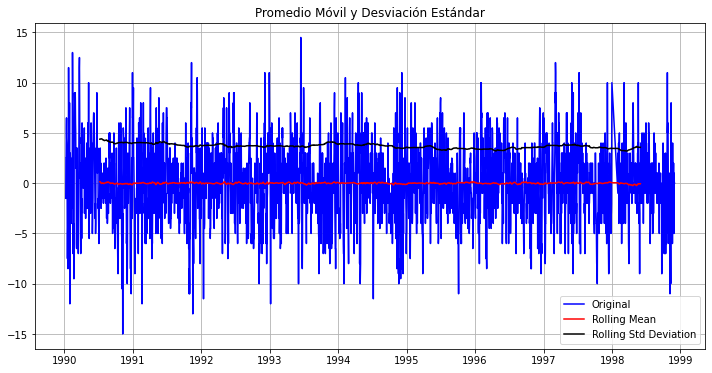

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.031921e+00
p-value                        1.947987e-12
#Lags Used                     2.900000e+01
Number of Observations Used    3.188000e+03
Critical Value (1%)           -3.432403e+00
Critical Value (5%)           -2.862447e+00
Critical Value (10%)          -2.567253e+00
dtype: float64


In [70]:
##TEMPERATURA MÍNIMA
#Probamos la estacionaridad
ts_test_log_diff_2.dropna(inplace=True)
test_stationarity(ts_test_log_diff_2)

* Pronóstico de la Serie de Tiempo
> Ya que hemos obtenido una serie de tiempo estacionaria, construiremos un modelo utilizando diferenciación, porque es fácil añadir el error, la tendencia y la estacionalidad a las predicciones. 

 > Esto con base en el ***método ARIMA***.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


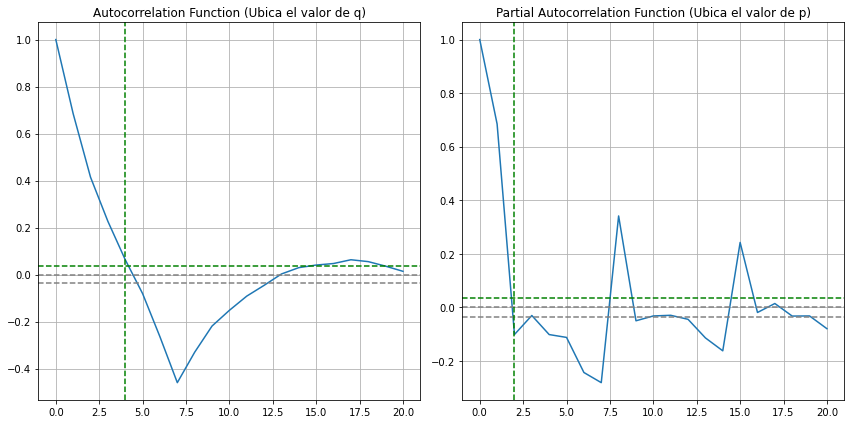

In [71]:
#Utilizamos el método ARIMA 


##TEMPERATURA MÁXIMA
lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

#Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

#Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=4, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


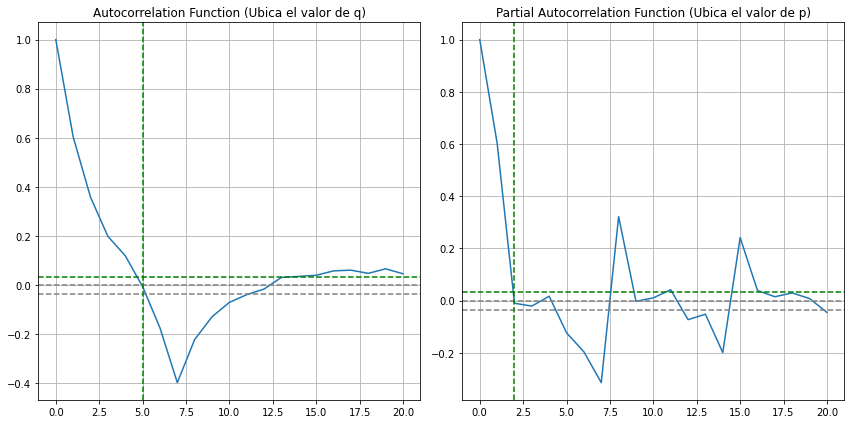

In [72]:
#Utilizamos el método ARIMA 

##TEMPERATURA MÍNIMA
lag_acf = acf(ts_test_log_diff_2, nlags=20)
lag_pacf = pacf(ts_test_log_diff_2, nlags=20, method = 'ols')

#Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

#Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff_2)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff_2)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=5, linestyle='--', color='green')
#es x=4.5 aproximadamente pero el entero más cercano es 5
plt.axvline(x=5, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff_2)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff_2)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

* Construimos los modelos ARIMA para cada Temperatura (Tmax y Tmin)
* Contrastamos la bondad del ajuste en cada caso
* Calculamos el error de la raíz cuadrada promedio RMSE 
* Sobreponemos gráficamente ambas series, la observada y la construida con el método ARIMA.



> Modelo AR (Auto-Regresión)



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 3224
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -8055.925
Method:                       css-mle   S.D. of innovations              2.944
Date:                Sat, 20 Feb 2021   AIC                          16119.850
Time:                        02:42:14   BIC                          16144.164
Sample:                             1   HQIC                         16128.564
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0021      0.042      0.051      0.959      -0.080       0.084
ar.L1.D.Tmax    -0.0934      0.017     -5.364      0.000      -0.128      -0.059
ar.L2.D.Tmax    -0.1488      0.017     -8.53

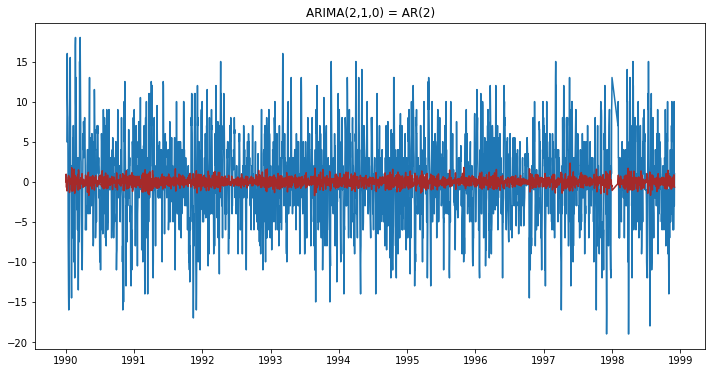

In [73]:
##TEMPERATURA MÁXIMA
#Modelo AR(p): (p,d,q) = (2,1,0) 
#p es donde cruza el PACF el primer nivel de confianza superior, que en la gráfica derecha es cercana a 2, por lo que p=2.
model = ARIMA(ts_test_tmax, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 3224
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -7199.426
Method:                       css-mle   S.D. of innovations              2.257
Date:                Sat, 20 Feb 2021   AIC                          14406.852
Time:                        02:42:15   BIC                          14431.165
Sample:                             1   HQIC                         14415.565
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0007      0.029      0.023      0.981      -0.055       0.057
ar.L1.D.Tmin    -0.2223      0.017    -12.801      0.000      -0.256      -0.188
ar.L2.D.Tmin    -0.1670      0.017     -9.62

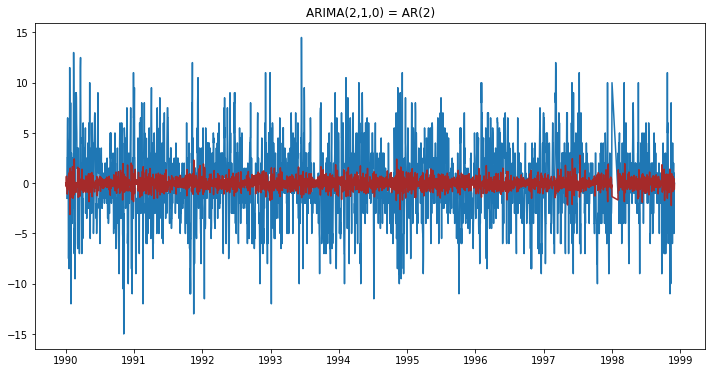

In [74]:
##TEMPERATURA MÍNIMA
#Modelo AR(p): (p,d,q) = (2,1,0) 
#p es donde cruza el PACF el primer nivel de confianza superior, que en la gráfica derecha es cercana a 2, por lo que p=2.
model = ARIMA(ts_test_tmin, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff_2)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())


> Modelo MA (Promedio Móvil)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 3224
Model:                 ARIMA(0, 1, 4)   Log Likelihood               -7930.010
Method:                       css-mle   S.D. of innovations              2.831
Date:                Sat, 20 Feb 2021   AIC                          15872.020
Time:                        02:42:15   BIC                          15908.490
Sample:                             1   HQIC                         15885.090
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0017      0.014      0.120      0.905      -0.026       0.030
ma.L1.D.Tmax    -0.1862      0.017    -10.686      0.000      -0.220      -0.152
ma.L2.D.Tmax    -0.2250      0.017    -12.99

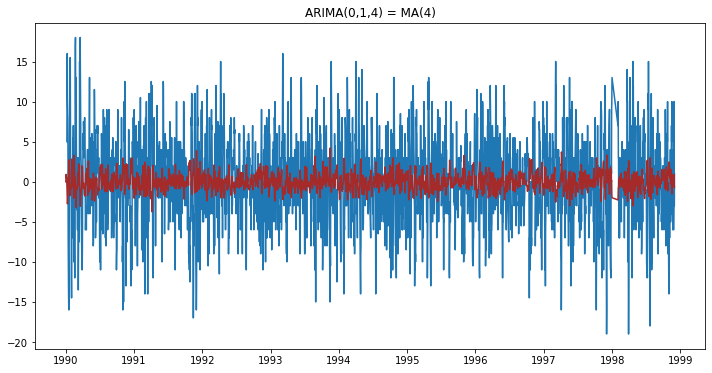

In [75]:
###TEMPERATURA MÁXIMA
#Modelo MA(q): (p,d,q) = (0,1,4) 
#q es donde cruza la ACF el primer nivel de confianza superior, cercano a 4, por lo que haremos q=4.  
model = ARIMA(ts_test_tmax, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 3224
Model:                 ARIMA(0, 1, 5)   Log Likelihood               -7089.616
Method:                       css-mle   S.D. of innovations              2.181
Date:                Sat, 20 Feb 2021   AIC                          14193.232
Time:                        02:42:16   BIC                          14235.780
Sample:                             1   HQIC                         14208.480
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0008      0.013      0.063      0.950      -0.025       0.026
ma.L1.D.Tmin    -0.2997      0.018    -17.016      0.000      -0.334      -0.265
ma.L2.D.Tmin    -0.1881      0.018    -10.27

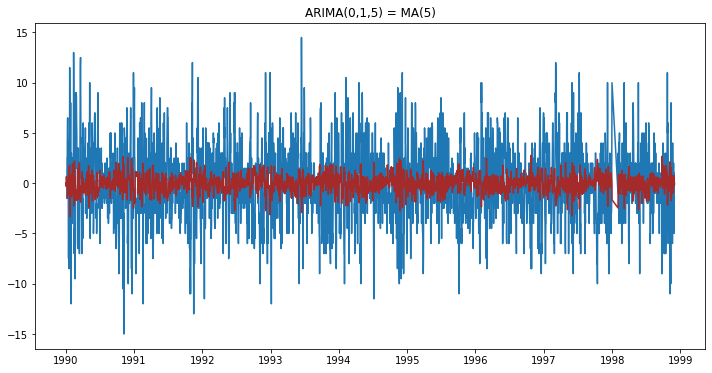

In [76]:
###TEMPERATURA MÍNIMA
#Modelo MA(q): (p,d,q) = (0,1,5) 
#q es donde cruza la ACF el primer nivel de confianza superior, cercano a 5, por lo que haremos q=5.  
model = ARIMA(ts_test_tmin, order=(0,1,5), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff_2)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,5) = MA(5)')
print(results_MA.summary())

> Modelo ARIMA (Auto-Regresión + Promedio Móvil)




/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 3224
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -7925.924
Method:                       css-mle   S.D. of innovations              2.827
Date:                Sat, 20 Feb 2021   AIC                          15867.847
Time:                        02:42:19   BIC                          15916.474
Sample:                             1   HQIC                         15885.274
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0017      0.013      0.125      0.900      -0.025       0.028
ar.L1.D.Tmax     0.0426      0.344      0.124      0.901      -0.632       0.718
ar.L2.D.Tmax     0.1883      0.201      0.93

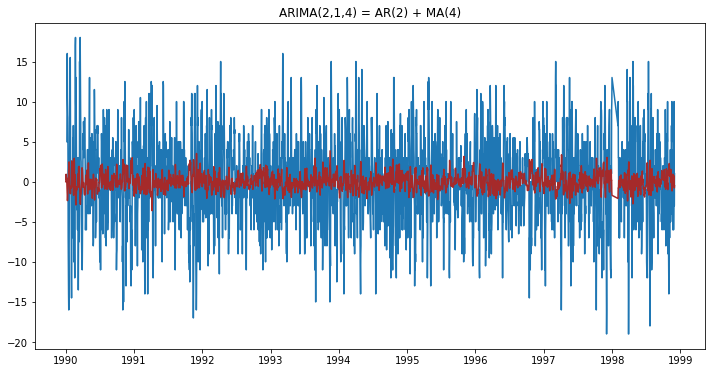

In [77]:
###TEMPERATURA MÁXIMA
#Modelo MA(q): (p,d,q) = (2,1,4) 
#p es donde cruza el PACF el primer nivel de confianza superior, que en la gráfica derecha es cercana a 2, por lo que p=2.
#q es donde cruza la ACF el primer nivel de confianza superior, cercano a 4, por lo que haremos q=4.  
model = ARIMA(ts_test_tmax, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 3224
Model:                 ARIMA(2, 1, 5)   Log Likelihood               -7089.228
Method:                       css-mle   S.D. of innovations              2.181
Date:                Sat, 20 Feb 2021   AIC                          14196.455
Time:                        02:42:22   BIC                          14251.161
Sample:                             1   HQIC                         14216.061
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0008      0.013      0.063      0.950      -0.024       0.026
ar.L1.D.Tmin    -0.1113      0.364     -0.306      0.760      -0.824       0.602
ar.L2.D.Tmin     0.2639      0.237      1.11

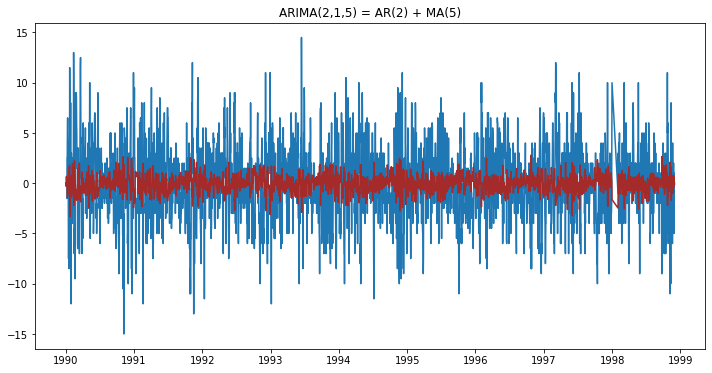

In [78]:
###TEMPERATURA MÍNIMA
#Modelo MA(q): (p,d,q) = (2,1,5) 
#p es donde cruza el PACF el primer nivel de confianza superior, que en la gráfica derecha es cercana a 2, por lo que p=2.
#q es donde cruza la ACF el primer nivel de confianza superior, cercano a 4, por lo que haremos q=5.  
model = ARIMA(ts_test_tmin, order=(2,1,5), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff_2)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,5) = AR(2) + MA(5)')
print(results_ARIMA.summary())

* Predicciones


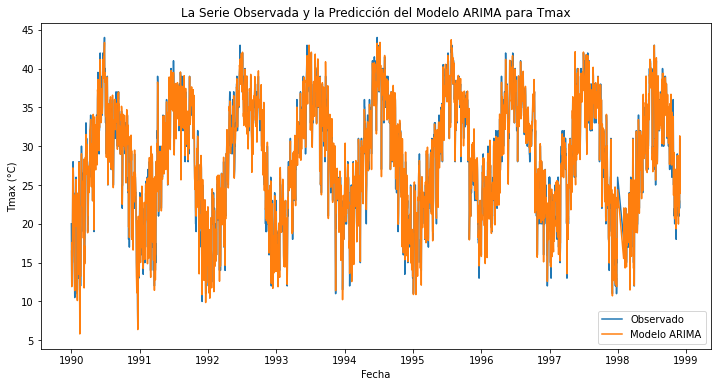

In [84]:
#RESULTADOS OBTENIDOS

#AIC
###TEMPERATURA MÁXIMA
#AR: 16119.850
#MA:  15872.020
#ARIMA: 15867.847
#NOTAMOS QUE EL VALOR MENOR ES EL QUE SE OBTUVO CON EL MÉTODO ARIMA AR()+MA()

#Definiremos series de tiempo para hacer las predicciones con el método de ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
#Le sumamos las predicciones de ARIMA a la serie observada
predictions_ARIMA = pd.Series(ts_test_tmax, index = ts_test_tmax.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff)
# Graficamos la serie original y las predicciones con ARIMA
# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(ts_test_tmax, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (°C)')
plt.title('La Serie Observada y la Predicción del Modelo ARIMA para Tmax')
plt.legend(loc='best');

In [80]:
#Calculamos el RMSE 
###TEMPERATURA MÁXIMA
RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test_tmax)**2))
print('RMSE:', RMSE)

RMSE: 0.8245190839611638


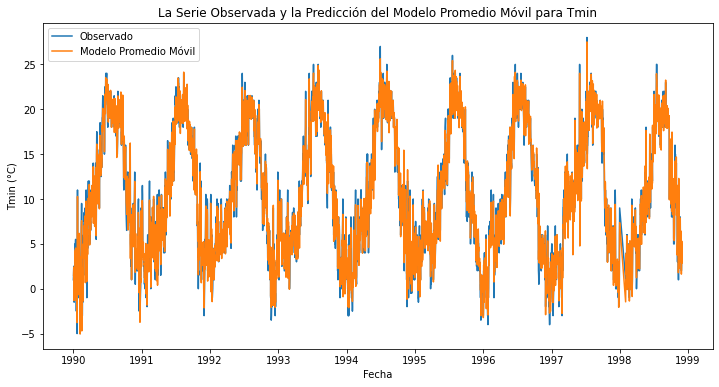

In [87]:
#RESULTADOS OBTENIDOS

#AIC
###TEMPERATURA MÍNIMA
#AR: 14406.852
#MA:  14193.232
#ARIMA: 14196.455
#NOTAMOS QUE EL VALOR MENOR ES EL QUE SE OBTUVO CON EL MÉTODO MA

#Definiremos series de tiempo para hacer las predicciones con el método de ARIMA
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)
#Le sumamos las predicciones de ARIMA a la serie observada
predictions_MA = pd.Series(ts_test_tmin, index = ts_test_tmin.index)
predictions_MA = predictions_MA.add(predictions_MA_diff)
# Graficamos la serie original y las predicciones con ARIMA
# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(ts_test_tmin, label='Observado');
plt.plot(predictions_MA, label='Modelo Promedio Móvil');
plt.xlabel('Fecha')
plt.ylabel('Tmin (°C)')
plt.title('La Serie Observada y la Predicción del Modelo Promedio Móvil para Tmin')
plt.legend(loc='best');

In [88]:
#Calculamos el RMSE 
###TEMPERATURA MÍNIMA
RMSE = np.sqrt(np.mean((predictions_MA - ts_test_tmin)**2))
print('RMSE:', RMSE)

RMSE: 0.8276001838726231
